This notebook implements a facial emotion recognition system using the FER2013 dataset. A pre-trained Vision Transformer (ViT) model is fine-tuned in PyTorch for multi-class emotion classification.

To improve generalization, data augmentation techniques are applied during training, including MixUp augmentation.


# Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import cv2
from sklearn.metrics import confusion_matrix,roc_curve
import os
from os import name
import datetime
import torch
import kagglehub
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from PIL import Image
from torchvision.transforms import InterpolationMode
from collections import Counter
import torch
import torch.nn as nn
import math
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from transformers import ViTForImageClassification
import math

# Dataset Loading

In [ ]:
path = kagglehub.dataset_download("deadskull7/fer2013")

print("Path to dataset files:", path)

100%|██████████| 96.6M/96.6M [00:00<00:00, 132MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/deadskull7/fer2013/versions/1


In [ ]:
os.listdir(path)

['fer2013.csv']

In [ ]:
path=os.path.join(path,'fer2013.csv')

In [ ]:
df=pd.read_csv(path)

In [ ]:
df

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


# Data preprocessing

In [ ]:
emotion_labels = {
    0: "Angry",
    1: "Disgust",
    2: "Fear",
    3: "Happy",
    4: "Sad",
    5: "Surprise",
    6: "Neutral"
}


class FERDataset(Dataset):
    def __init__(self, dataframe, usage, transform=None):
        self.data = dataframe[dataframe["Usage"] == usage].reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        label = int(row["emotion"])

        pixels = np.array(row["pixels"].split(), dtype=np.uint8)
        image = pixels.reshape(48, 48)

        image = Image.fromarray(image)

        if image.mode != "RGB":
            image = image.convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, label


from torchvision import transforms

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Grayscale(num_output_channels=3),   # ensure 3 channels for ViT
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std),
])

train_dataset = FERDataset(df, usage="Training", transform=train_transform)
val_dataset   = FERDataset(df, usage="PublicTest", transform=transform)
test_dataset  = FERDataset(df, usage="PrivateTest", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32,num_workers=2,pin_memory=True, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=32,num_workers=2,pin_memory=True,shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=32,num_workers=0,pin_memory=False, shuffle=False)


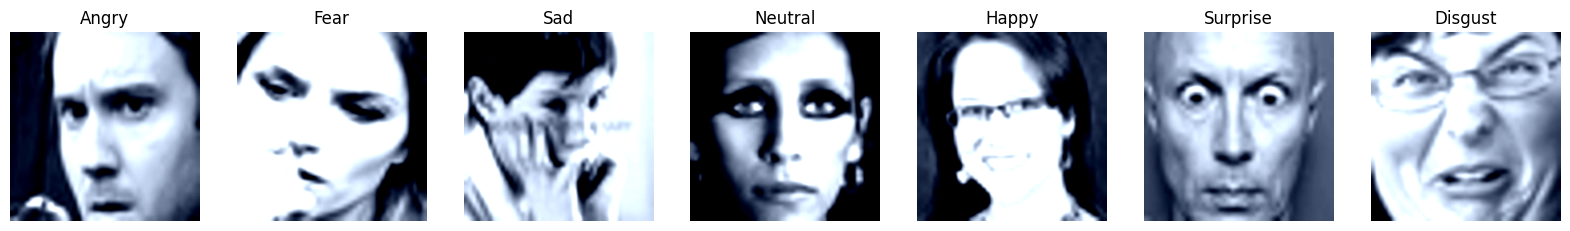

In [ ]:
def plot_one_image_per_class(dataset, class_names, n_classes=7):
    seen_classes = set()
    fig, axs = plt.subplots(1, n_classes, figsize=(20, 3))

    i = 0
    for img, label in dataset:
        if label not in seen_classes:
            axs[i].imshow(img.permute(1, 2, 0).numpy() * 0.5 + 0.5)  # unnormalize
            axs[i].set_title(class_names[label])
            axs[i].axis("off")
            seen_classes.add(label)
            i += 1
            if i == n_classes:
                break
    plt.show()

plot_one_image_per_class(train_dataset, emotion_labels)


Training class distribution:
Class 0 (Angry): 3995
Class 1 (Disgust): 436
Class 2 (Fear): 4097
Class 3 (Happy): 7215
Class 4 (Sad): 4830
Class 5 (Surprise): 3171
Class 6 (Neutral): 4965


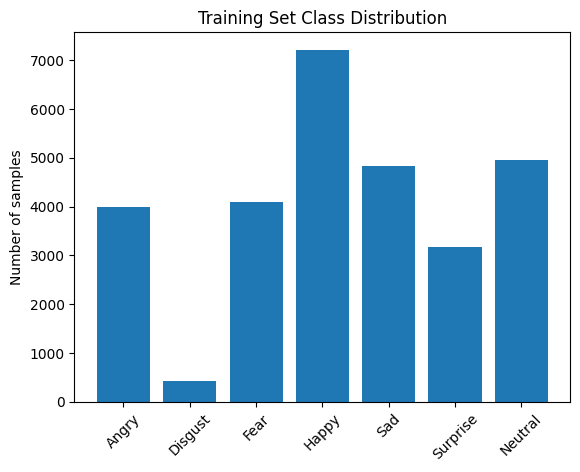

In [ ]:
train_labels = [label for _, label in train_dataset]
label_counts = Counter(train_labels)

print("Training class distribution:")

classes = list(range(7))
counts = [label_counts[c] for c in classes]
names = [emotion_labels[c] for c in classes]

for c, name, count in zip(classes, names, counts):
    print(f"Class {c} ({name}): {count}")

plt.bar(names, counts)
plt.xticks(rotation=45)
plt.ylabel("Number of samples")
plt.title("Training Set Class Distribution")
plt.show()


The FER2013 dataset exhibits significant class imbalance, with certain emotions (e.g., Disgust) being underrepresented compared to others (e.g., Happy). This imbalance can bias the model toward majority classes and negatively impact generalization.

To address this, a class-balanced sampling strategy is used during training. Class weights are computed as the inverse of class frequencies, and a WeightedRandomSampler is applied to the training dataloader. This ensures that minority classes are sampled more frequently, resulting in a more balanced class distribution across training batches.

In [ ]:
class_counts = [3995, 436, 4097, 7215, 4830, 3171, 4965]

weights = 1. / torch.tensor(class_counts, dtype=torch.float)

train_labels = train_dataset.data["emotion"].values

sample_weights = [weights[label] for label in train_labels]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=sampler,
    num_workers=2,
    pin_memory=True
)



def check_sampler_distribution(dataloader, num_batches=200):
    all_labels = []
    for i, (_, labels) in enumerate(dataloader):
        if i >= num_batches:
            break
        all_labels.extend(labels.tolist())
    counts = Counter(all_labels)
    print("\n[Sampler Distribution Check (first", num_batches, "batches)]")
    for cls, count in sorted(counts.items()):
        print(f" Class {cls}: {count}")
    print()

check_sampler_distribution(train_loader)



[Sampler Distribution Check (first 200 batches)]
 Class 0: 970
 Class 1: 971
 Class 2: 847
 Class 3: 918
 Class 4: 919
 Class 5: 896
 Class 6: 879



# Model Training and Evaluation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


num_classes     = 7
batch_size      = 32
num_epochs      = 12
warmup_epochs   = 3
patience        = 5
best_val_loss   = float("inf")
epochs_no_improve = 0


model = ViTForImageClassification.from_pretrained(
    "google/vit-base-patch16-224-in21k",
    num_labels=num_classes,
).to(device)

# Replace classifier with dropout + linear
in_features = model.classifier.in_features
model.classifier = nn.Sequential(
    nn.Dropout(0.4),
    nn.Linear(in_features, num_classes)

).to(device)

# Freeze embeddings + first encoder layer
for param in model.vit.embeddings.parameters():
    param.requires_grad = False

for layer in model.vit.encoder.layer[:1]:
    for param in layer.parameters():
        param.requires_grad = False

print("Frozen layers: embeddings + fist encoder block")


optimizer = AdamW([
    {"params": [p for n, p in model.vit.named_parameters() if p.requires_grad], "lr": 6e-5},
    {"params": model.classifier.parameters(), "lr": 8e-4}
])



def hybrid_schedule(total_epochs=12):
    def lr_lambda(epoch):
        # Phase 1: Warmup (0 → 3)
        if epoch < 3:
            return epoch / 3.0  # linear warmup from 0 → 1

        # Phase 2: Plateau (3 → 6)
        elif epoch < 6:
            return 1.0  # steady LR at max

        # Phase 3: Cosine Decay (6 → 12)
        else:
            progress = (epoch - 6) / (total_epochs - 6)  # normalized 0 → 1
            return 0.5 * (1 + math.cos(math.pi * progress))  # cosine decay from 1 → 0

    return lr_lambda


scheduler = LambdaLR(
    optimizer,
    lr_lambda=[
        hybrid_schedule(total_epochs=12),  # ViT schedule
        hybrid_schedule(total_epochs=12)   # Classifier
    ]
)

criterion = nn.CrossEntropyLoss()



def mixup_data(x, y, alpha=9, device="cuda"):
    lam = np.random.beta(alpha, alpha) if alpha > 0 else 1
    batch_size = x.size(0)
    index = torch.randperm(batch_size).to(device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, preds, y_a, y_b, lam):
    return lam * criterion(preds, y_a) + (1 - lam) * criterion(preds, y_b)


def train_one_epoch(model, dataloader, optimizer, criterion, device, epoch, num_epochs, mixup_alpha=9, mixup_prob=0.5):
    model.train()
    total_loss, correct, total = 0, 0, 0

    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # MixUp
        if np.random.rand() < mixup_prob:
            images, targets_a, targets_b, lam = mixup_data(images, labels, alpha=mixup_alpha, device=device)
            outputs = model(pixel_values=images)
            loss = mixup_criterion(criterion, outputs.logits, targets_a, targets_b, lam)
        else:
            outputs = model(pixel_values=images)
            loss = criterion(outputs.logits, labels)

        loss.backward()
        optimizer.step()

        # Track metrics
        total_loss += loss.item() * labels.size(0)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss, correct, total = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(pixel_values=images)
            loss = criterion(outputs.logits, labels)

            total_loss += loss.item()
            preds = outputs.logits.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return total_loss / len(dataloader), correct / total, np.array(all_preds), np.array(all_labels)

# Training Loop
history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}

for epoch in range(num_epochs):

    scheduler.step()

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, epoch, num_epochs)
    val_loss, val_acc, val_preds, val_labels = evaluate(model, val_loader, criterion, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["train_acc"].append(train_acc)
    history["val_acc"].append(val_acc)

    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f" Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f" Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}")
    print(f" Current LRs: {[g['lr'] for g in optimizer.param_groups]}")

    if (best_val_loss - val_loss) >0:
            best_val_loss = val_loss
            best_preds, best_labels = val_preds, val_labels
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_vit.pth")
            print(f" Saved Best Model! (val_loss improved)")



    else:
        epochs_no_improve += 1
        print(f" No improvement, Patience: {epochs_no_improve}/{patience}")


    if epochs_no_improve >= patience:
        print("\n Early stopping triggered!")
        break

print("Training Finished. Best Val Loss:", best_val_loss)

Using device: cuda


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Frozen layers: embeddings + fist encoder block

Epoch [1/12]
 Train Loss: 1.4682, Train Acc: 0.4307
 Val Loss:   1.0739, Val Acc:   0.5926
 Current LRs: [1.9999999999999998e-05, 0.0002666666666666667]
 Saved Best Model! (val_loss improved)

Epoch [2/12]
 Train Loss: 1.2745, Train Acc: 0.5174
 Val Loss:   0.9832, Val Acc:   0.6266
 Current LRs: [3.9999999999999996e-05, 0.0005333333333333334]
 Saved Best Model! (val_loss improved)

Epoch [3/12]
 Train Loss: 1.2049, Train Acc: 0.5395
 Val Loss:   0.9520, Val Acc:   0.6604
 Current LRs: [6e-05, 0.0008]
 Saved Best Model! (val_loss improved)

Epoch [4/12]
 Train Loss: 1.1343, Train Acc: 0.5732
 Val Loss:   0.9692, Val Acc:   0.6551
 Current LRs: [6e-05, 0.0008]
 No improvement, Patience: 1/5

Epoch [5/12]
 Train Loss: 1.1032, Train Acc: 0.5791
 Val Loss:   0.9297, Val Acc:   0.6785
 Current LRs: [6e-05, 0.0008]
 Saved Best Model! (val_loss improved)

Epoch [6/12]
 Train Loss: 1.0357, Train Acc: 0.6130
 Val Loss:   1.0202, Val Acc:   0.6570


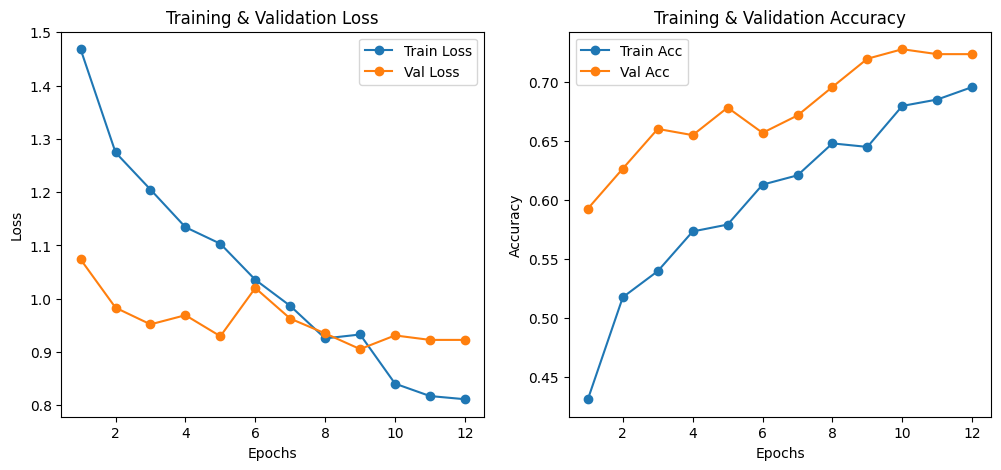

In [ ]:
epochs_range = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history["train_loss"], label="Train Loss", marker="o")
plt.plot(epochs_range, history["val_loss"], label="Val Loss", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history["train_acc"], label="Train Acc", marker="o")
plt.plot(epochs_range, history["val_acc"], label="Val Acc", marker="o")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

plt.show()

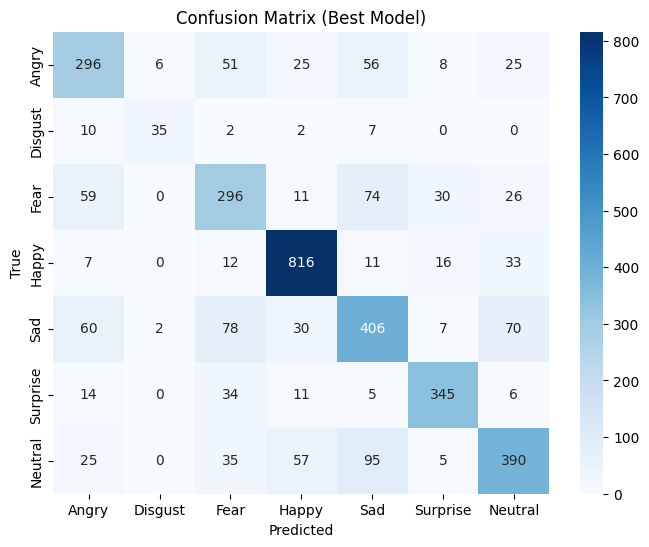

In [ ]:
class_names = ["Angry","Disgust","Fear","Happy","Sad","Surprise","Neutral"]

cm = confusion_matrix(best_labels, best_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Best Model)")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(best_labels, best_preds, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

       Angry       0.63      0.63      0.63       467
     Disgust       0.81      0.62      0.71        56
        Fear       0.58      0.60      0.59       496
       Happy       0.86      0.91      0.88       895
         Sad       0.62      0.62      0.62       653
    Surprise       0.84      0.83      0.84       415
     Neutral       0.71      0.64      0.67       607

    accuracy                           0.72      3589
   macro avg       0.72      0.69      0.71      3589
weighted avg       0.72      0.72      0.72      3589



In [ ]:
model.eval()
test_loss, correct, total = 0, 0, 0

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(pixel_values=images)
        loss = criterion(outputs.logits, labels)

        test_loss += loss.item() * labels.size(0)
        preds = torch.argmax(outputs.logits, dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

avg_test_loss = test_loss / total
test_accuracy = correct / total

print(f"\n Test Loss: {avg_test_loss:.4f}")
print(f" Test Accuracy: {test_accuracy * 100:.2f}%")



 Test Loss: 0.9004
 Test Accuracy: 72.78%


# Conclusion

A Vision Transformer (ViT) was fine-tuned on the FER2013 dataset using a combination of class-balanced sampling and MixUp augmentation to mitigate class imbalance and improve generalization.

Training was stabilized through a hybrid learning rate schedule (warmup, plateau, cosine decay), freezing of the ViT embedding layers and the first transformer encoder block throughout training, and separate learning rates for the backbone and classification head. This setup enabled effective adaptation of the pre-trained model while limiting overfitting.

The final model achieved a test accuracy of 72.78%, with strong performance on majority classes and competitive results on underrepresented emotions such as Disgust. The macro-averaged F1-score reflects balanced performance across emotion categories despite the dataset’s challenging distribution.

Overall, this work demonstrates that Vision Transformers can perform competitively on facial emotion recognition tasks when paired with appropriate sampling, augmentation, and optimization strategies, and provides a solid baseline for further experimentation or real-time applications.